**Time Series Analysis - Project 2: XGBoost (Extreme Gradient Boosting)**

**Model Accuracy: 95.78% (non-rolling), 92.37 % (rollling)** <br>
**In this project we will be predicting sales data using ** <br>
**The dataset can be found here: https://github.com/ritvikmath/Time-Series-Analysis/blob/master/catfish.csv**

**Importing libraries**

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance

**Importing the dataset**

In [32]:
df = pd.read_csv("/Users/willbarnard/Downloads/catfish.csv", parse_dates=[0], index_col=[0], date_format = '%Y-%m-%d')
df = df.asfreq(pd.infer_freq(df.index))

start_date = datetime(1986, 1, 1)
end_date = datetime(2004, 1, 1)
lim_df = df[start_date:end_date]

In [33]:
lim_df.head()

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239


**Checking for erroneous data entries**

In [34]:
print("Missing values:\n", lim_df.isnull().sum())

Missing values:
 Total    0
dtype: int64


**Displaying dataset statistical metrics (EDA)**

In [35]:
print("Dataset Summary:\n", lim_df.describe())

Dataset Summary:
               Total
count    217.000000
mean   19392.400922
std     5253.746842
min     8196.000000
25%    15486.000000
50%    19500.000000
75%    23576.000000
max    30485.000000


**Displaying the total dataset**

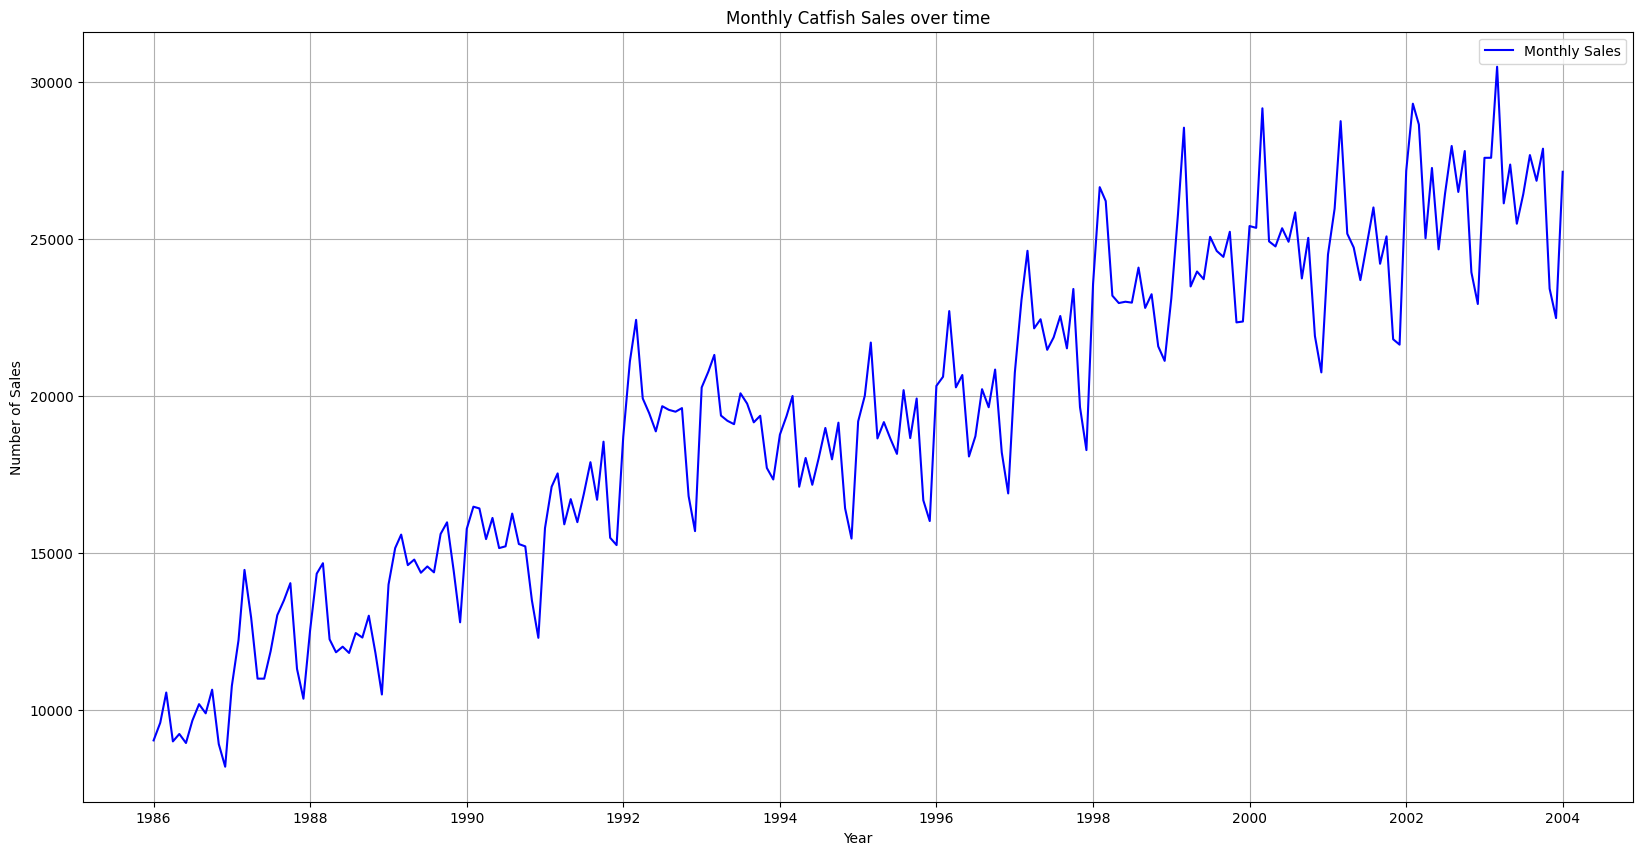

In [36]:
plt.figure(figsize=(20, 10))
plt.plot(lim_df.index, lim_df["Total"], label="Monthly Sales", color="blue")
plt.xlabel("Year")
plt.ylabel("Number of Sales")
plt.title("Monthly Catfish Sales over time")
plt.legend()
plt.grid()
plt.show()

**Cross-Correlation Analysis**

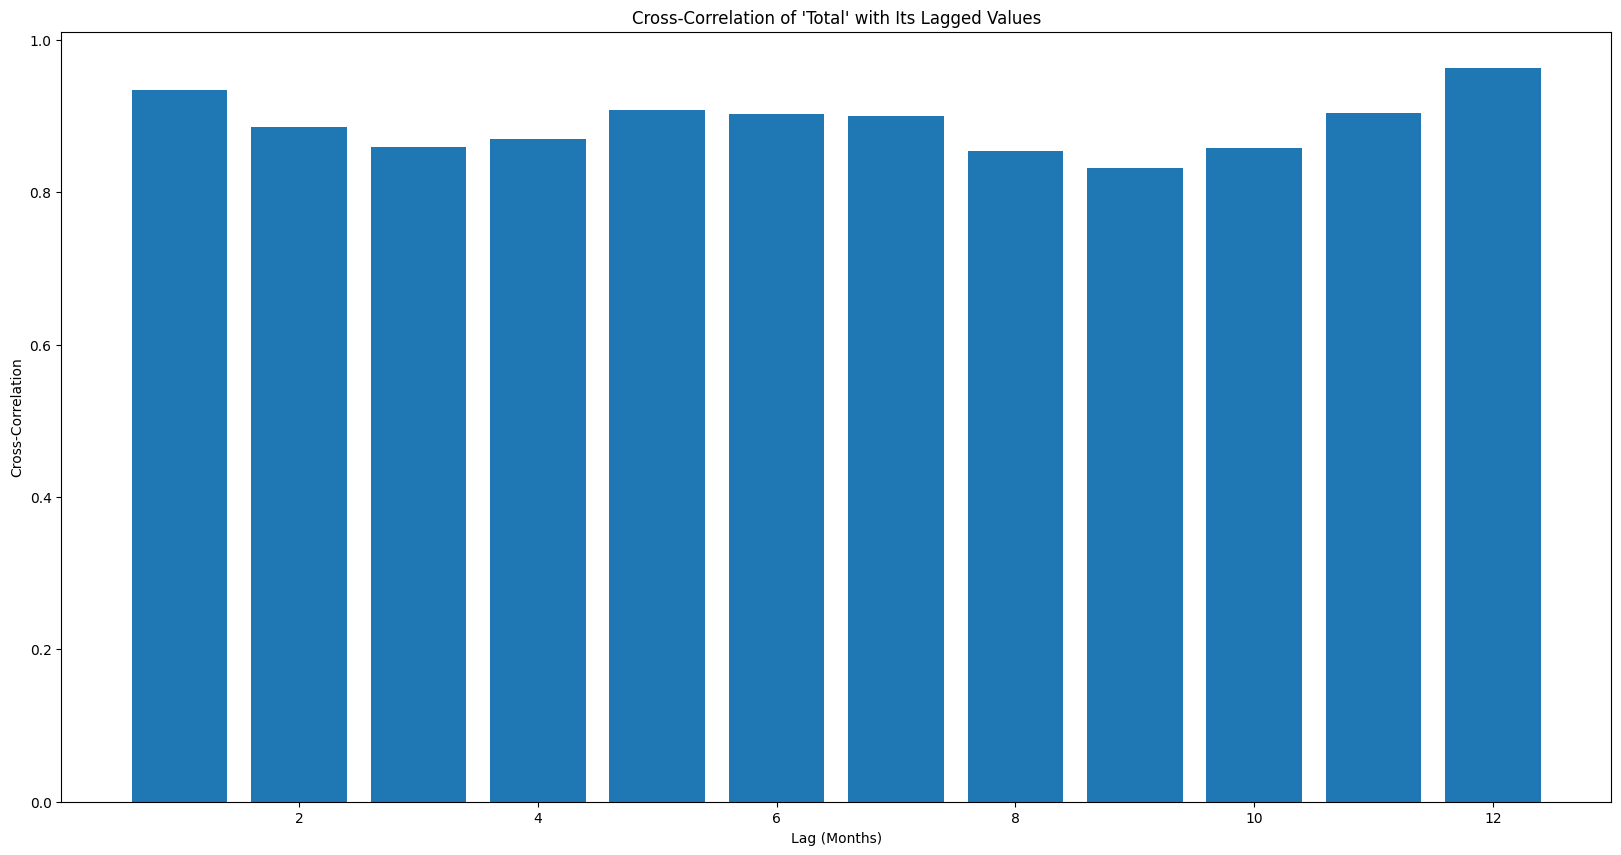

In [37]:

lags = np.arange(1, 12 + 1)  
correlations = [lim_df['Total'].corr(lim_df['Total'].shift(lag)) for lag in lags]

plt.figure(figsize=(20, 10))
plt.bar(lags, correlations)
plt.xlabel("Lag (Months)")
plt.ylabel("Cross-Correlation")
plt.title("Cross-Correlation of 'Total' with Its Lagged Values")
plt.show()

**Selecting significant lags**

In [38]:

significant_lags = [lag for lag, corr in zip(lags, correlations) if abs(corr) > 0.3]
print("Significant Lags:", significant_lags)


Significant Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


**Performing feature engineering on the dataset**

In [39]:
df_features = lim_df.copy()
    
for i in range(1, 12 + 1):
    df_features[f"Lag_{i}"] = df_features["Total"].shift(i)

df_features["Year"] = df_features.index.year
df_features["Month"] = df_features.index.month
df_features["Quarter"] = df_features.index.quarter

df_features["Rolling_3"] = df_features["Total"].rolling(window=3).mean()  
df_features["Rolling_6"] = df_features["Total"].rolling(window=6).mean() 
df_features["Rolling_12"] = df_features["Total"].rolling(window=12).mean()


df_features = df_features.dropna()





df_features.head()

,Total,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Year,Month,Quarter,Rolling_3,Rolling_6,Rolling_12
Date,,,,,,,,,,,,,,,,,,,
1987-01-01,10768,8196.0,8917.0,10649.0,9896.0,10188.0,9668.0,8951.0,9239.0,9002.0,10558.0,9596.0,9034.0,1987,1,1,9293.666667,9769.000000,9635.666667
1987-02-01,12220,10768.0,8196.0,8917.0,10649.0,9896.0,10188.0,9668.0,8951.0,9239.0,9002.0,10558.0,9596.0,1987,2,1,10394.666667,10107.666667,9854.333333
1987-03-01,14463,12220.0,10768.0,8196.0,8917.0,10649.0,9896.0,10188.0,9668.0,8951.0,9239.0,9002.0,10558.0,1987,3,1,12483.666667,10868.833333,10179.750000
1987-04-01,12944,14463.0,12220.0,10768.0,8196.0,8917.0,10649.0,9896.0,10188.0,9668.0,8951.0,9239.0,9002.0,1987,4,2,13209.000000,11251.333333,10508.250000
1987-05-01,11001,12944.0,14463.0,12220.0,10768.0,8196.0,8917.0,10649.0,9896.0,10188.0,9668.0,8951.0,9239.0,1987,5,2,12802.666667,11598.666667,10655.083333


**Adding Fourier Terms**

In [56]:
time = np.arange(len(df_features))

for k in range(1, 4):
    df_features[f'sin_{k}'] = np.sin(2 * np.pi * k * time / 12)
    df_features[f'cos_{k}'] = np.cos(2 * np.pi * k * time / 12)


**Displaying Fourier Terms**

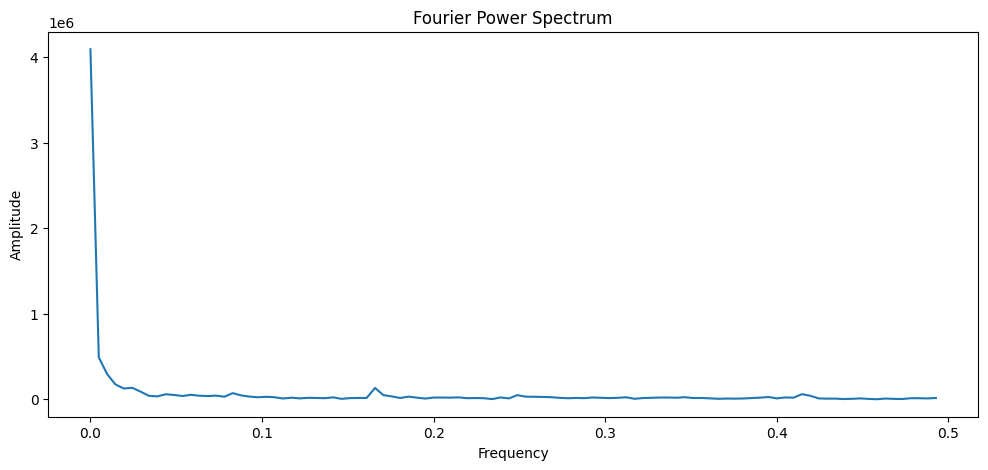

In [88]:
from scipy.fftpack import fft
fft_vals = fft(df_features["Total"])
freqs = np.fft.fftfreq(len(fft_vals))

plt.figure(figsize=(12, 5))
plt.plot(freqs[:len(freqs)//2], np.abs(fft_vals[:len(fft_vals)//2]))  
plt.title("Fourier Power Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()


**Splitting the dataset into testing and training**

In [57]:
X = df_features.drop(columns=["Total"])
y = df_features["Total"]

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training size: {len(X_train)}, Testing size: {len(X_test)}")

Training size: 164, Testing size: 41


**Hyperparameter tuning using random search**

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],  # Number of boosting rounds
    'max_depth': [3, 5, 7, 10],           # Tree depth (higher = more complex)
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Shrinkage factor
    'subsample': [0.6, 0.8, 1.0],         # % of samples per tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # % of features per tree
    'gamma': [0, 0.1, 0.2, 0.5],          # Minimum loss reduction to make a split
    'lambda': [0.01, 0.1, 1, 10]          # L2 regularization
}

tscv = TimeSeriesSplit(n_splits=5)
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=30,  
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1,  
    random_state=42
)


search.fit(X_train, y_train)


print("Best Hyperparameters:", search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=1.0, gamma=0.1, lambda=0.1, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, lambda=0.1, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, lambda=0.01, learning_rate=0.05, max_depth=10, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, lambda=0.1, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, lambda=0.01, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, lambda=0.01, learning_rate=0.05, max_depth=10, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, lambda=0.1, learning_rate=0.2, max_depth=5, n_estimators=500,

**Defining the XGBoost model**

In [59]:
xgb_model = XGBRegressor(subsample=0.8, n_estimators=50, max_depth=7, learning_rate=0.2, gamma=0.2, colsample_by_tree=1.0)
xgb_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:08:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "colsample_by_tree" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by_tree=1.0, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None, ...)

**Calculating predictions**

In [60]:
y_pred = xgb_model.predict(X_test)

**Error metric: MAPE**

In [61]:
residuals = y_test - y_pred
residuals
print('Mean Absolute Percent error: ', round(np.mean(abs(residuals/y_test)), 4))

Mean Absolute Percent error:  0.0422


**Other error metrics**

In [62]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" Model Performance Metrics:")
print(f" Mean Absolute Error (MAE): {mae:.2f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f" R² Score: {r2:.2f}")

 Model Performance Metrics:
 Mean Absolute Error (MAE): 1091.04
 Root Mean Squared Error (RMSE): 1409.53
 R² Score: 0.60


**Displaying predictions**

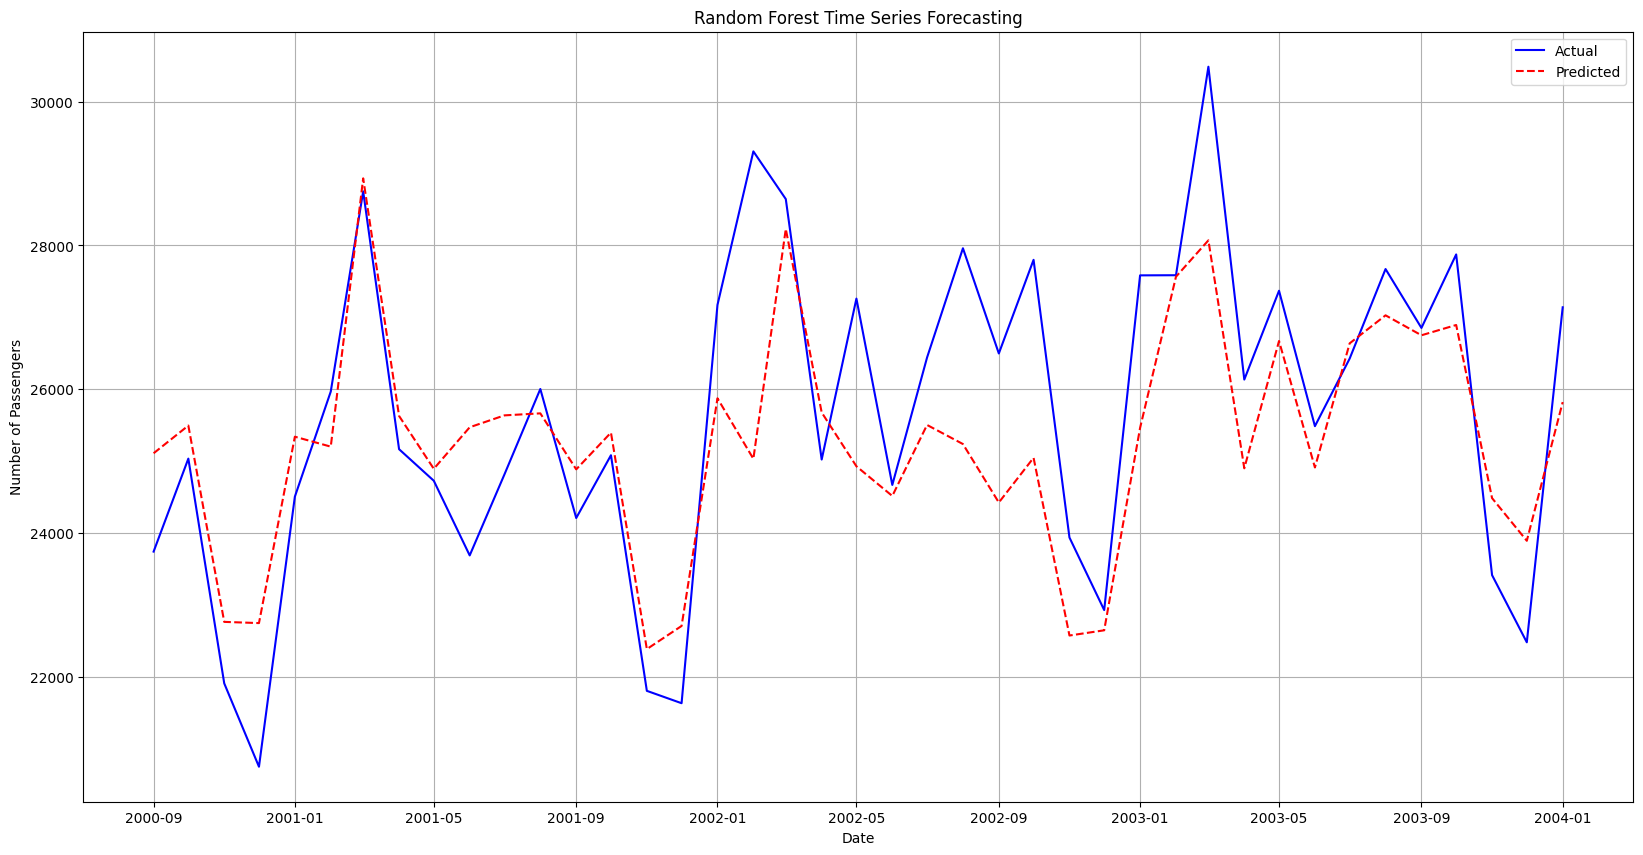

In [63]:
plt.figure(figsize=(20, 10))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.title("Random Forest Time Series Forecasting")
plt.legend()
plt.grid()
plt.show()

**Displaying total dataset**

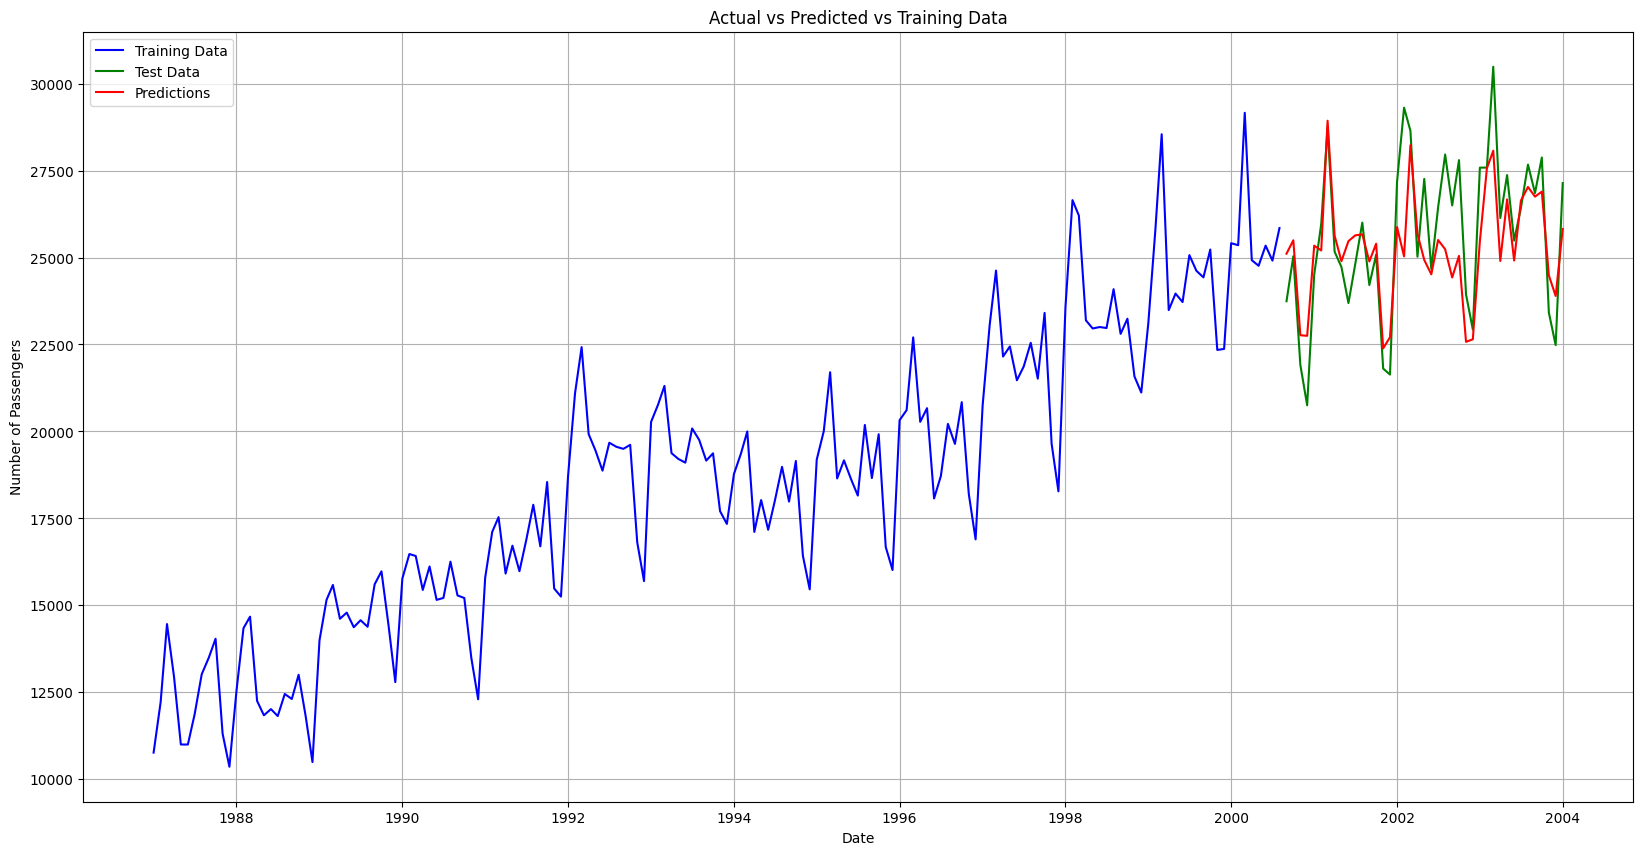

In [64]:
plt.figure(figsize=(20, 10))

plt.plot(y_train.index, y_train, label="Training Data", color="blue")
plt.plot(y_test.index, y_test, label="Test Data", color="green")
plt.plot(y_test.index, y_pred, label="Predictions", color="red")

plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.title("Actual vs Predicted vs Training Data")
plt.legend()

plt.grid(True)
plt.show()


**Calculating rolling predictions**

In [65]:
forecast = []
history_X = X_train.copy()
history_y = y_train.copy()

for t in range(len(X_test)):
    X_input = history_X.iloc[-1:].values  
    y_pred = xgb_model.predict(X_input)[0]
    forecast.append(y_pred)

  
    new_row_X = X_test.iloc[t:t+1]  
    new_row_X["Lag_1"] = y_pred 
    history_X = pd.concat([history_X, new_row_X]).iloc[1:]  
    history_y = pd.concat([history_y, pd.Series([y_pred], index=[X_test.index[t]])])


y_rolling_pred = np.array(forecast)

/var/folders/2v/t8ll2w9151nf9h3myq7ks4xh0000gn/T/ipykernel_30876/3982684762.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row_X["Lag_1"] = y_pred


**Error metric: MAPE**

In [66]:
residuals = y_test - y_rolling_pred
residuals
print('Mean Absolute Percent error: ', round(np.mean(abs(residuals/y_test)), 4))

Mean Absolute Percent error:  0.0763


**Other error metrics**

In [67]:
mae = mean_absolute_error(y_test, y_rolling_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_rolling_pred))
r2 = r2_score(y_test, y_rolling_pred)

print(f" Model Performance Metrics:")
print(f" Mean Absolute Error (MAE): {mae:.2f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f" R² Score: {r2:.2f}")

 Model Performance Metrics:
 Mean Absolute Error (MAE): 1964.04
 Root Mean Squared Error (RMSE): 2359.99
 R² Score: -0.12


**Displaying rolling predictions**

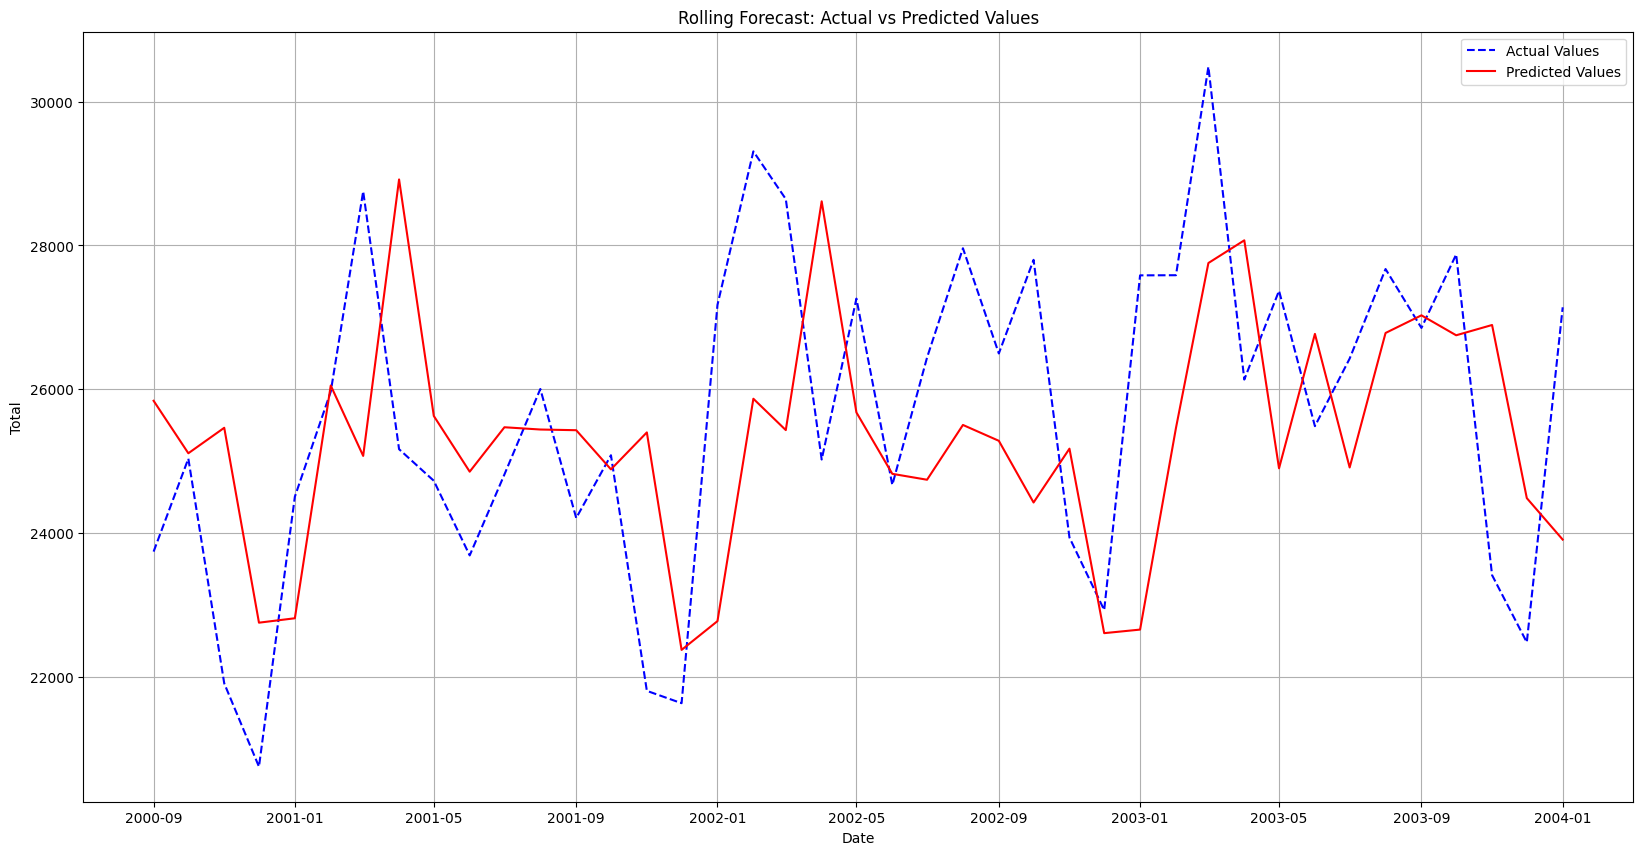

In [68]:
plt.figure(figsize=(20, 10))

plt.plot(y_test.index, y_test.values, label='Actual Values', color='blue', linestyle='--')
plt.plot(y_test.index, y_rolling_pred, label='Predicted Values', color='red', linestyle='-')

plt.title('Rolling Forecast: Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Total')
plt.legend()

plt.grid(True)
plt.show()

**Displaying total dataset**

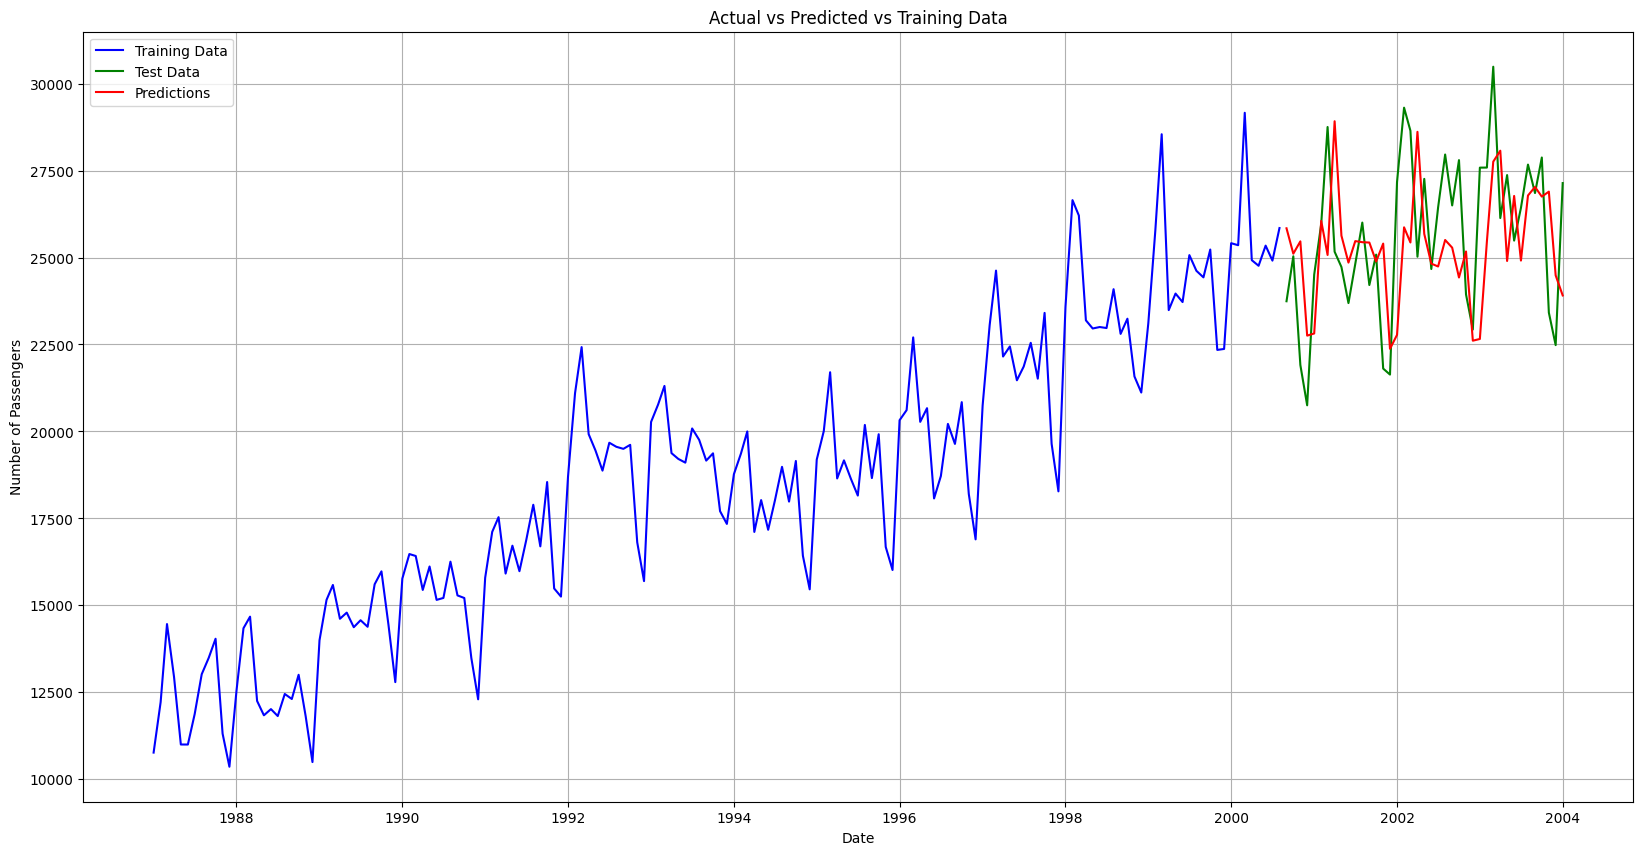

In [69]:
plt.figure(figsize=(20, 10))

plt.plot(y_train.index, y_train, label="Training Data", color="blue")
plt.plot(y_test.index, y_test, label="Test Data", color="green")
plt.plot(y_test.index, y_rolling_pred, label="Predictions", color="red")

plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.title("Actual vs Predicted vs Training Data")
plt.legend()

plt.grid(True)
plt.show()

**Model interpretation: Feature importance**

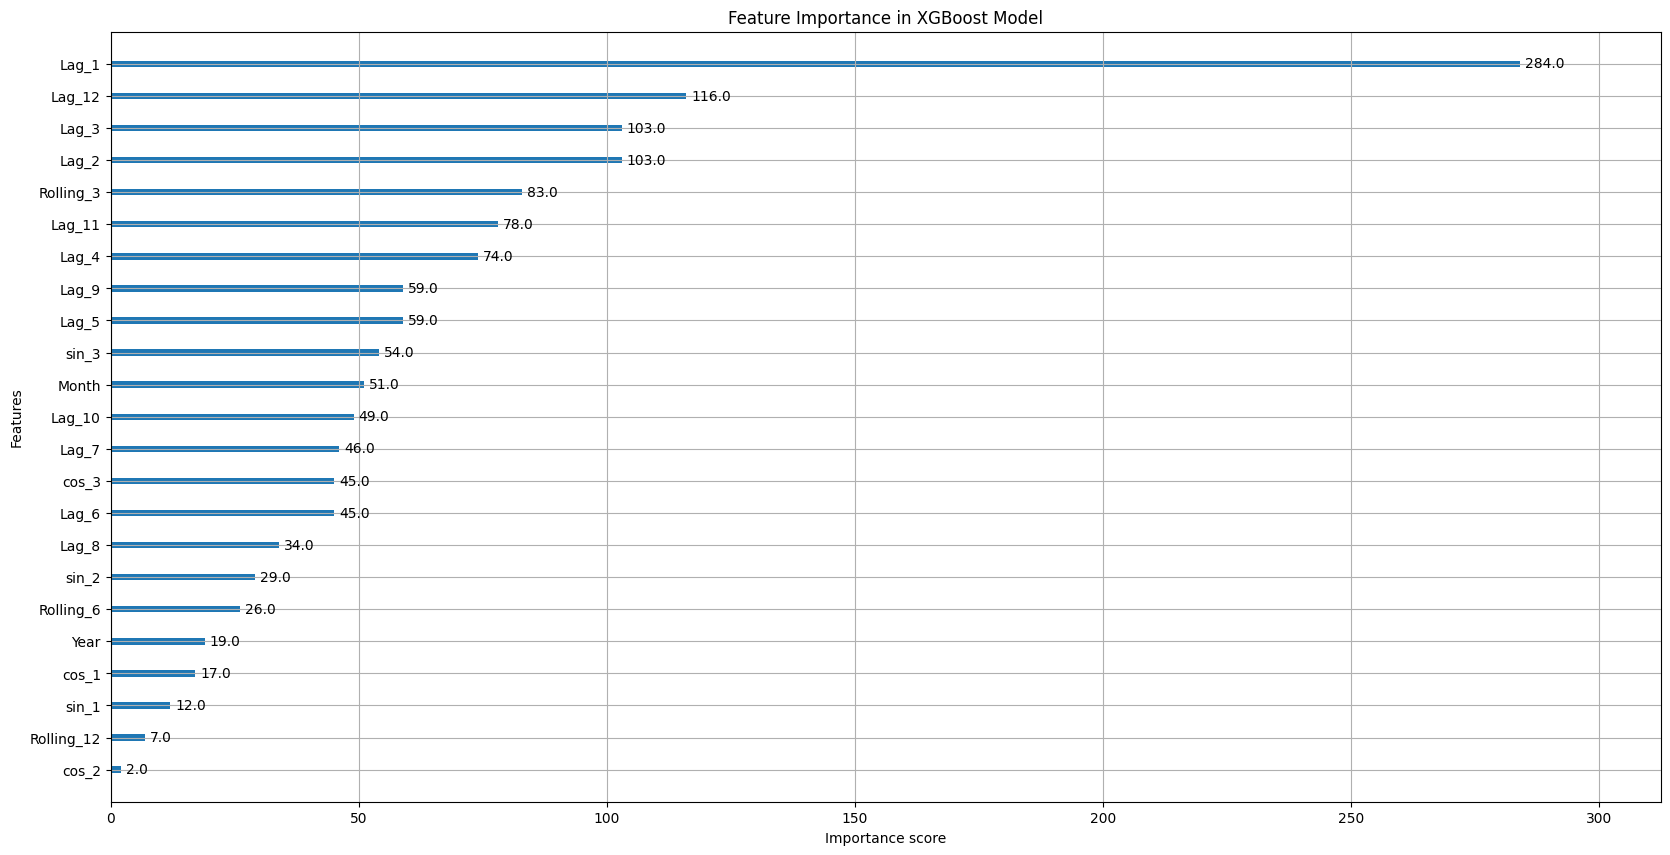

In [ ]:
fig, ax =plt.subplots(figsize=(20, 10))
plot_importance(xgb_model, ax=ax)
plt.title("Feature Importance in XGBoost Model")
plt.show()